In [1]:
%%capture
"""
Use the trained machine learing models to predict 5-day ahead closed price of a stock
"""

In [2]:
company = "AAPL"

In [3]:
"""
Designate development or production use 

development = False
production = True
"""
DEV_PROD = True

"""
Designate whether visualisation to be exported to a PNG file
"""
export_visual = True

"""
Designate whether to archive forecast results
"""
save_results = True

In [6]:
import AlgoTraderLib.DataProcessor as data_pro
import AlgoTraderLib.PredictionEvaluator as pred_eval
from AlgoTraderLib.NeuralNet import NeuralNet

Using TensorFlow backend.


In [7]:
import copy
from datetime import datetime, date
from keras.models import load_model
import numpy as np
import pandas as pd

from bokeh.io import show, output_notebook, export_png
output_notebook()

Loading BokehJS ...

In [8]:
def find_model(company, search_path):
    file_name = ""
    for file in os.listdir(search_path):
        # File name contains company, only expecting 1 unique file
        if company in file:
            file_name = file
            break

    if os.path.exists(file_path):
        return file_path
    else:
        return None

In [9]:
""" Load the trained stock model """

model_path = find_model(company, final_model_path)
try:
    stock_model = NeuralNet()
    stock_model.load_trained_model(file_path=model_path)
except Exception as e:
    print(e)

In [10]:
""" Retrieve real-time stock price data """

def get_daily_price(company, interval=data_pro.MONTH_6, save_path=daily_price_path):
    # Check save-path and remove old file if present
    for file in os.listdir(save_path):
        if company in file:
            # Remove old data file
            os.remove(save_path + file)
    
    """ Retrieve stock prices in an interval """
    today_date = datetime.today().date()
    start_date = today_date - interval

    # Use Pandas function retrieve the data as a data-frame and save to file
    stock_df = pd.read_json(api_call.format(company, start_date, today_date, api_token))
    file_name = "{0}-{1}.csv".format(company, today_date)
    price_data_path = save_path + file_name
    stock_df.to_csv(price_data_path)
    
    if os.path.exists(price_data_path):
        # Check if file saved correctly
        return price_data_path
    else:
        return None

In [11]:
latest_price = get_daily_price(company)
stock_df = data_pro.get_stock_dataframe2(company, daily_price_path, use_adjusted=False)
stock_df = data_pro.insert_indicators(stock_df, use_adjusted=False)
stock_df.shape

(123, 21)

In [13]:
data_parameter = {"input-steps": 10,
                  "output-steps": 5,
                  "days-per-batch": 5,
                  "output": ["close"]}

In [14]:
input_data, date_index = data_pro.make_forecast_input(stock_df,
                                                      retrospect=data_parameter["input-steps"],
                                                      num_window_points_in=data_parameter["days-per-batch"],
                                                      num_steps_out=data_parameter["output-steps"]
                                                     )
print(len(input_data))
print(input_data[-1].shape)
print(len(date_index))

5
(10, 21)
5


In [16]:
""" Make forecast """
sd_stock_pred = stock_model.forecast(input_data)

""" Convert back to original scale """
price_forecast = data_pro.restore_forecast_outputs(sd_stock_pred,
                                                   source_df=stock_df,
                                                   data_labels=data_parameter["output"],
                                                   date_index=date_index,
                                                   retrospect=data_parameter["input-steps"],
                                                   num_window_points_in=data_parameter["days-per-batch"]
                                                  )

In [17]:
close_pred = price_forecast[data_parameter["output"][0]]
close_pred

,y,y+1,y+2,y+3,y+4
2019-05-30,175.460358,175.056519,174.689743,176.914368,183.744949
2019-05-31,174.956726,176.483475,177.582886,182.265656,181.632538
2019-06-03,180.401932,180.239090,183.729507,185.409439,191.081223
2019-06-04,181.817398,182.110275,183.985168,186.729736,193.794144
2019-06-05,179.469833,185.349503,187.511673,193.745804,198.477921


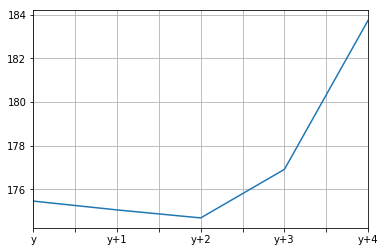

In [18]:
close_pred.iloc[0].plot(grid=True)

In [19]:
forecast_plot = data_pro.plot_forecast(company, forecast_df=close_pred, data_parameter=data_parameter,
                                       legend_loc="bottom_right")
show(forecast_plot)

In [20]:
current_date = date.today()
date_fmt = "%Y-%m-%d"

if export_visual:
    archive_file = "{0}-{1}.png".format(company, current_date.strftime(date_fmt))
    file_name = "{0}.png".format(company)
    export_png(forecast_plot, file_path)
    export_png(forecast_plot, archive_path)

if save_results:
    result_archive = "{0}-{1}.csv".format(company, current_date.strftime(date_fmt))
    close_pred.to_csv(archive_path)